**Reinforcement Learning for Betting Strategy**



This Kaggle notebook demonstrates the implementation of a reinforcement learning-based betting strategy using the Stable-Baselines3 library and the Proximal Policy Optimization (PPO) algorithm. The goal is to train a model to make betting decisions based on historical data, and then evaluate its performance on a separate test dataset.



1. **Data Loading and Preprocessing:**
   - Imports necessary libraries including Gym, Pandas, and Stable-Baselines3.
   - Defines hyperparameters and loads the historical dataset for training.
   - Creates a custom Gym environment (`BettingEnvironment`) for the betting scenario.

2. **Training the PPO Model:**
   - Initializes the PPO model using the defined environment.
   - Performs training over a specified number of epochs, collecting trajectories and updating the model.
   - Saves the trained PPO model for future use.

3. **Testing and Evaluation:**
   - Defines a new Gym environment for testing using a separate test dataset.
   - Loads the pre-trained PPO model and evaluates its performance on the test dataset.
   - Calculates and plots metrics such as episode rewards, mean rewards, and profit percentage increase over time.

4. **Predictions and Visualization:**
   - Uses the trained model to predict bet amounts on a new dataset (`prediction_data`).
   - Saves the predicted bet amounts and the entire dataset with predictions to CSV files.
   - Visualizes the testing results, including episode rewards, mean rewards, and profit percentage increase, providing insights into the model's behavior.

5. **Conclusion and Future Work:**
   - Summarizes the key findings and performance metrics of the trained model.
   - Suggests potential areas for improvement or future exploration, such as hyperparameter tuning or using different reinforcement learning algorithms.


A comprehensive workflow for developing, training, and evaluating a reinforcement learning model for a betting strategy. Users can adapt the provided code for their specific datasets and experiment with different hyperparameters to optimize the model's performance.



In [1]:
!pip install 'shimmy>=0.2.1'
!pip install stable_baselines3
!pip install torch torchvision




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 30.1 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: Gymnasium 0.26.3
    Uninstalling Gymnasium-0.26.3:
      Successfully uninstalled Gymnasium-0.26.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.3 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import numpy as np
import gym
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import torch

# Define hyperparameters
bet_increment = 5000  # Increment in bet amount
max_bet = 10000  # Maximum bet amount
min_bet = 1000  # Minimum bet amount
starting_balance = 5000000  # Initial balance
profit_to_be_maintained = 0.00000001  # Desired profit to maintain
total_timesteps = 1000  # Total training timesteps (adjust as needed)
learning_rate = 0.0003  # Learning rate for the PPO algorithm
epochs = 10  # Number of training epochs
validation_ratio = 0.2  # Validation dataset ratio
test_ratio = 0.1  # Test dataset ratio

# Define the path to your dataset
data_file_path = "/kaggle/input/winloose-dataset/filtered_odds_positive.csv"  # Update with your data file path

# Load your dataset
df = pd.read_csv(data_file_path)
win_loss_outcomes = df['odds_positive'].values

# Use only the first 100 rows of data for testing (you can adjust this)
train_data = win_loss_outcomes[:1000]

# Define a custom Gym environment for betting
class BettingEnvironment(gym.Env):
    # Constructor for the environment
    def __init__(self):
        # Define action space (discretized bet amounts)
        self.action_space = gym.spaces.Discrete(int((max_bet - min_bet) / bet_increment) + 1)

        # Define observation space (game conditions and balance)
        self.observation_space = gym.spaces.Box(
            low=np.array([0.0, 0.0, min_bet, 0.0]),  # [game_type, odds, min_bet, balance]
            high=np.array([1.0, 1.0, max_bet, starting_balance]),
        )

        self.balance = starting_balance
        self.current_step = 0
        self.odds = 0  # Initialize odds

    # Execute an action (bet) in the environment
    def step(self, action):
        # Convert action to a bet amount
        bet_amount = min_bet + action * bet_increment

        # Get the game result (1 for win, 0 for loss) from your dataset
        game_result = train_data[self.current_step]
        self.current_step += 1

        # Set 'odds' to the game result (win/loss)
        self.odds = game_result

        # Calculate profit based on the bet amount and game result
        profit = bet_amount if game_result == 1 else -bet_amount

        # Update the balance
        self.balance += profit

        # Define the reward (e.g., negative profit)
        reward = -profit

        # Define done condition (e.g., when balance falls below a threshold or all data is used)
        done = self.balance <= (1.0 - profit_to_be_maintained) * starting_balance or self.current_step >= len(train_data)

        # Update the observation
        self.observation = [0.0, self.odds, min_bet, self.balance]

        return self.observation.copy(), reward, done, {}

    # Reset the environment
    def reset(self):
        self.balance = starting_balance
        self.observation = [0.0, 0.0, min_bet, self.balance]
        self.current_step = 0
        self.odds = 0  # Reset odds
        return self.observation.copy()

# Create and wrap the environment using DummyVecEnv
env = BettingEnvironment()
env = DummyVecEnv([lambda: env])

# Check if CUDA (GPU) is available and select the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the PPO model with the appropriate device
model = PPO("MlpPolicy", env, verbose=1, learning_rate=learning_rate, device=device)

# Lists to store training progress for plotting
training_rewards = []  # To store training rewards
validation_rewards = []  # To store validation rewards

# Training loop
for epoch in range(epochs):
    # Collect trajectories using the current policy model
    trajectories = []
    for _ in range(total_timesteps):
        obs = env.reset()
        done = False
        episode_rewards = 0
        episode_traj = []

        while not done:
            action, _ = model.predict(obs)
            next_obs, reward, done, _ = env.step(action)

            episode_traj.append((obs, action, reward, next_obs, done))
            episode_rewards += reward
            obs = next_obs

        trajectories.append(episode_traj)
        print(f"Epoch {epoch}/{epochs}: Episode Reward: {episode_rewards}")

    # Here, you should add the rest of your training and validation code,
    # which includes evaluating the model's performance and saving the trained model.

    average_validation_reward = 0  # Calculate average validation reward (you need to complete this part)
    validation_rewards.append(average_validation_reward)

    # Save the trained model (you can add this part at the appropriate location in your code)
    model.save("ppo_betting_model")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [6000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10: Episode Reward: [1000.]
Epoch 0/10

/opt/conda/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Testing Results: Total Episodes: 1000, Final Balance: [8565000.]
Mean Rewards over Last 10 Episodes: [3000.0, 2500.0, 2000.0, 2500.0, 2500.0, 2000.0, 2500.0, 2500.0, 2500.0, 2500.0, 3000.0, 3000.0, 3500.0, 3000.0, 3000.0, 3500.0, 3500.0, 3500.0, 3000.0, 3500.0, 3000.0, 3500.0, 3500.0, 3500.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 3500.0, 4000.0, 3500.0, 3500.0, 4000.0, 3500.0, 3500.0, 3000.0, 3000.0, 3500.0, 3500.0, 3500.0, 3500.0, 3000.0, 2500.0, 3000.0, 2500.0, 2500.0, 2500.0, 2500.0, 2500.0, 2500.0, 2500.0, 2500.0, 2500.0, 2000.0, 2500.0, 3000.0, 3000.0, 2500.0, 3000.0, 3000.0, 3500.0, 4000.0, 4000.0, 4000.0, 3500.0, 3000.0, 3500.0, 4000.0, 4000.0, 4000.0, 3500.0, 3500.0, 4000.0, 4500.0, 5000.0, 5000.0, 5000.0, 4500.0, 4500.0, 4500.0, 5000.0, 5000.0, 5000.0, 5000.0, 4500.0, 5000.0, 4500.0, 4500.0, 4500.0, 4000.0, 3500.0, 3500.0, 3500.0, 3500.0, 4000.0, 3500.0, 4000.0, 4500.0, 4500.0, 5000.0, 5000.0, 5000.0, 5000.0, 4500.0, 4500.0, 4500.0, 4500.0, 4000.0, 3500.0, 3000.0, 3500.0, 30

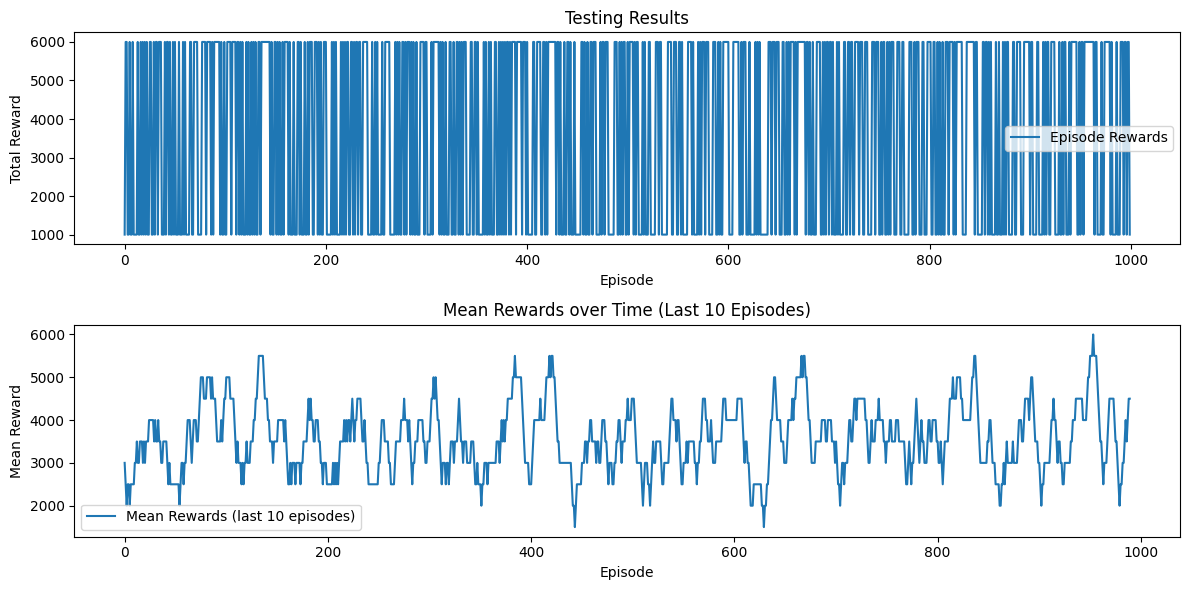

In [3]:
# Import necessary libraries
import numpy as np
import gym
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import matplotlib.pyplot as plt

# Define hyperparameters
bet_increment = 5000  # Increment in bet amount
max_bet = 10000  # Maximum bet amount
min_bet = 1000  # Minimum bet amount
starting_balance = 5000000  # Initial balance
profit_to_be_maintained = 0.00000001  # Desired profit to maintain
total_timesteps = 1000  # Total testing timesteps (adjust as needed)

# Define the path to your dataset
data_file_path = "/kaggle/input/winloose-dataset/filtered_odds_positive.csv"  # Update with your data file path

# Load your dataset
df = pd.read_csv(data_file_path)
win_loss_outcomes = df['odds_positive'].values

# Use only the next 100000 rows of data for testing (you can adjust this)
test_data = win_loss_outcomes[1000:2000]

# Define a custom Gym environment for betting
class BettingEnvironment(gym.Env):
    # Constructor for the environment
    def __init__(self):
        # Define action space (discretized bet amounts)
        self.action_space = gym.spaces.Discrete(int((max_bet - min_bet) / bet_increment) + 1)

        # Define observation space (game conditions and balance)
        self.observation_space = gym.spaces.Box(
            low=np.array([0.0, 0.0, min_bet, 0.0]),  # [game_type, odds, min_bet, balance]
            high=np.array([1.0, 1.0, max_bet, starting_balance]),
        )

        self.balance = starting_balance
        self.current_step = 0
        self.odds = 0  # Initialize odds

    # Execute an action (bet) in the environment
    def step(self, action):
        # Convert action to a bet amount
        bet_amount = min_bet + action * bet_increment

        # Get the game result (1 for win, 0 for loss) from your dataset
        game_result = test_data[self.current_step]
        self.current_step += 1

        # Set 'odds' to the game result (win/loss)
        self.odds = game_result

        # Calculate profit based on the bet amount and game result
        profit = bet_amount if game_result == 1 else -bet_amount

        # Update the balance
        self.balance += profit

        # Define the reward (e.g., negative profit)
        reward = -profit

        # Define done condition (e.g., when balance falls below a threshold or all data is used)
        done = self.balance <= (1.0 - profit_to_be_maintained) * starting_balance or self.current_step >= len(test_data)

        # Update the observation
        self.observation = [0.0, self.odds, min_bet, self.balance]

        return self.observation.copy(), reward, done, {}

    # Reset the environment
    def reset(self):
        self.balance = starting_balance
        self.observation = [0.0, 0.0, min_bet, self.balance]
        self.current_step = 0
        self.odds = 0  # Reset odds
        return self.observation.copy()

# Create and wrap the environment using DummyVecEnv
env = BettingEnvironment()
env = DummyVecEnv([lambda: env])

# Load the saved PPO model
model = PPO.load("ppo_betting_model")

# Lists to store testing progress for plotting
episode_rewards_history = []  # To store episode rewards
mean_rewards_history = []  # To store mean rewards

# Testing the model
test_balance = starting_balance

for _ in range(total_timesteps):
    obs = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action, _ = model.predict(obs)
        next_obs, reward, done, _ = env.step(action)
        episode_reward += reward
        obs = next_obs

    episode_rewards_history.append(episode_reward)
    test_balance += episode_reward

    if len(episode_rewards_history) > 10:
        mean_rewards_history.append(np.mean(episode_rewards_history[-10:]))

print(f"Testing Results: Total Episodes: {len(episode_rewards_history)}, Final Balance: {test_balance}")
print(f"Mean Rewards over Last 10 Episodes: {mean_rewards_history}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards_history, label="Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Testing Results")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(mean_rewards_history, label="Mean Rewards (last 10 episodes)")
plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.title("Mean Rewards over Time (Last 10 Episodes)")
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
# Import necessary libraries
import numpy as np
import gym
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import torch

# Define hyperparameters
bet_increment = 5000
max_bet = 10000
min_bet = 1000
starting_balance = 5000000

# Define the path to your dataset
data_file_path = "/kaggle/input/winloose-dataset/filtered_odds_positive.csv"

# Load your dataset
df = pd.read_csv(data_file_path)
win_loss_outcomes = df['odds_positive'].values

# Define a custom Gym environment for betting
class BettingEnvironment(gym.Env):
    def __init__(self):
        # Define action space
        self.action_space = gym.spaces.Discrete(int((max_bet - min_bet) / bet_increment) + 1)

        # Define observation space
        self.observation_space = gym.spaces.Box(
            low=np.array([0.0, 0.0, min_bet, 0.0]),
            high=np.array([1.0, 1.0, max_bet, starting_balance]),
        )

        self.balance = starting_balance
        self.current_step = 0
        self.odds = 0

    def step(self, action):
        # Convert action to a bet amount
        bet_amount = min_bet + action * bet_increment

        # Get the game result from your dataset
        game_result = win_loss_outcomes[self.current_step]
        self.current_step += 1

        self.odds = game_result
        profit = bet_amount if game_result == 1 else -bet_amount
        self.balance += profit

        reward = -profit
        done = self.balance <= 0 or self.current_step >= len(win_loss_outcomes)
        self.observation = [0.0, self.odds, min_bet, self.balance]

        return self.observation.copy(), reward, done, {}

    def reset(self):
        self.balance = starting_balance
        self.observation = [0.0, 0.0, min_bet, self.balance]
        self.current_step = 0
        self.odds = 0
        return self.observation.copy()

# Create and wrap the environment using DummyVecEnv
env = BettingEnvironment()
env = DummyVecEnv([lambda: env])

# Load the saved PPO model
model = PPO.load("ppo_betting_model")

# Create a copy of the dataset for predictions
prediction_data = df.copy().iloc[200000:210000]

# Lists to store predicted bet amounts
predicted_bets = []

# Loop through the prediction data
for index, row in prediction_data.iterrows():
    observation_features = [0.0, row['odds_positive'], min_bet, starting_balance]
    obs = np.array(observation_features)
    # Use the model to predict the action (bet amount)
    action, _ = model.predict(obs)
    # Convert the action to a bet amount
    bet_amount = min_bet + action * bet_increment


    # Save the predicted bet amount in a new column (e.g., 'predicted_bet')
    prediction_data.at[index, 'predicted_bet'] = bet_amount

    # Store the predicted bet amount
    predicted_bets.append(bet_amount)

# Save the dataset with predictions to a new CSV file
prediction_data.to_csv("predicted_data.csv", index=False)

# Optionally, you can also save the predicted bet amounts to a separate CSV
pd.DataFrame({'predicted_bet': predicted_bets}).to_csv("predicted_bets.csv", index=False)


/opt/conda/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Testing Results: Total Episodes: 1000, Final Balance: [8515000.]
Mean Rewards over Last 10 Episodes: [4000.0, 4000.0, 3500.0, 3500.0, 3500.0, 3000.0, 3000.0, 3000.0, 2500.0, 2500.0, 3000.0, 3500.0, 4000.0, 4000.0, 4500.0, 4500.0, 4000.0, 4500.0, 5000.0, 4500.0, 4000.0, 3500.0, 3000.0, 2500.0, 2500.0, 3000.0, 3000.0, 3000.0, 2500.0, 2500.0, 3000.0, 3000.0, 3000.0, 3000.0, 3000.0, 2500.0, 3000.0, 3000.0, 3500.0, 3500.0, 3000.0, 3000.0, 3500.0, 4000.0, 3500.0, 4000.0, 3500.0, 3500.0, 3500.0, 4000.0, 4500.0, 4500.0, 4500.0, 4000.0, 4000.0, 4000.0, 4500.0, 4000.0, 3500.0, 3500.0, 3000.0, 3000.0, 3000.0, 3500.0, 4000.0, 3500.0, 3500.0, 4000.0, 4500.0, 4500.0, 5000.0, 5000.0, 4500.0, 4500.0, 4500.0, 5000.0, 5000.0, 4500.0, 4000.0, 3500.0, 3500.0, 3500.0, 3500.0, 3000.0, 3000.0, 2500.0, 2000.0, 2500.0, 2500.0, 2500.0, 2000.0, 2500.0, 2500.0, 3000.0, 2500.0, 2500.0, 2500.0, 2500.0, 2500.0, 2500.0, 3000.0, 3000.0, 3000.0, 3000.0, 3000.0, 3000.0, 3500.0, 3000.0, 3000.0, 3000.0, 3000.0, 2500.0, 25

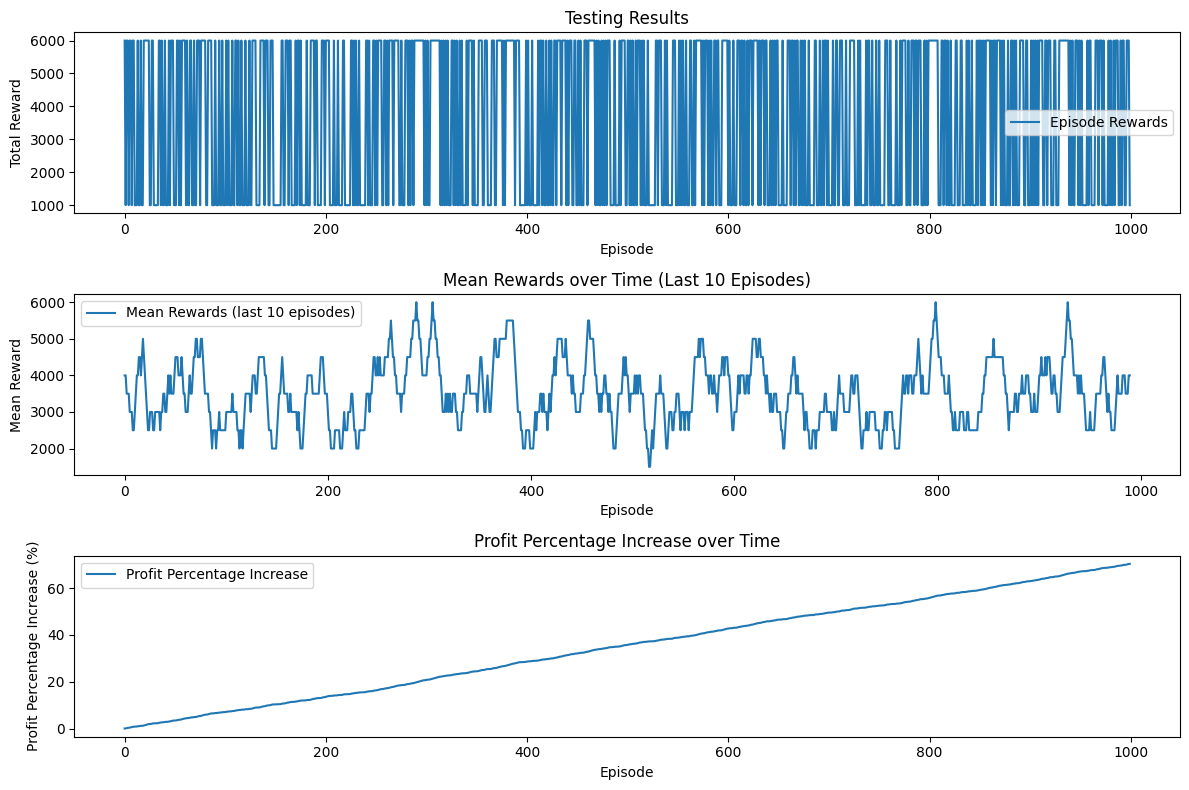

In [5]:
import numpy as np
import gym
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import matplotlib.pyplot as plt

# Define hyperparameters
bet_increment = 5000  # Increment in bet amount
max_bet = 10000  # Maximum bet amount
min_bet = 1000  # Minimum bet amount
starting_balance = 5000000  # Initial balance
profit_to_be_maintained = 0.00000001  # Desired profit to maintain
total_timesteps = 1000  # Total testing timesteps (adjust as needed)

# Define the path to your dataset
data_file_path = "/kaggle/input/winloose-dataset/filtered_odds_positive.csv"  # Update with your data file path

# Load your dataset
df = pd.read_csv(data_file_path)
win_loss_outcomes = df['odds_positive'].values

# Use only the next 100000 rows of data for testing (you can adjust this)
test_data = win_loss_outcomes[3000:4000]

# Define a custom Gym environment for betting
class BettingEnvironment(gym.Env):
    # Constructor for the environment
    def __init__(self):
        # Define action space (discretized bet amounts)
        self.action_space = gym.spaces.Discrete(int((max_bet - min_bet) / bet_increment) + 1)

        # Define observation space (game conditions and balance)
        self.observation_space = gym.spaces.Box(
            low=np.array([0.0, 0.0, min_bet, 0.0]),  # [game_type, odds, min_bet, balance]
            high=np.array([1.0, 1.0, max_bet, starting_balance]),
        )

        self.balance = starting_balance
        self.current_step = 0
        self.odds = 0  # Initialize odds

    # Execute an action (bet) in the environment
    def step(self, action):
        # Convert action to a bet amount
        bet_amount = min_bet + action * bet_increment

        # Get the game result (1 for win, 0 for loss) from your dataset
        game_result = test_data[self.current_step]
        self.current_step += 1

        # Set 'odds' to the game result (win/loss)
        self.odds = game_result

        # Calculate profit based on the bet amount and game result
        profit = bet_amount if game_result == 1 else -bet_amount

        # Update the balance
        self.balance += profit

        # Define the reward (e.g., negative profit)
        reward = -profit

        # Define done condition (e.g., when balance falls below a threshold or all data is used)
        done = self.balance <= (1.0 - profit_to_be_maintained) * starting_balance or self.current_step >= len(test_data)

        # Update the observation
        self.observation = [0.0, self.odds, min_bet, self.balance]

        return self.observation.copy(), reward, done, {}

    # Reset the environment
    def reset(self):
        self.balance = starting_balance
        self.observation = [0.0, 0.0, min_bet, self.balance]
        self.current_step = 0
        self.odds = 0  # Reset odds
        return self.observation.copy()

# Create and wrap the environment using DummyVecEnv
env = BettingEnvironment()
env = DummyVecEnv([lambda: env])

# Load the saved PPO model
model = PPO.load("ppo_betting_model")

# Lists to store testing progress for plotting
episode_rewards_history = []  # To store episode rewards
mean_rewards_history = []  # To store mean rewards
profit_percentage_history = []  # To store profit percentage increase

# Testing the model
test_balance = starting_balance

for _ in range(total_timesteps):
    obs = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action, _ = model.predict(obs)
        next_obs, reward, done, _ = env.step(action)
        episode_reward += reward
        obs = next_obs

    episode_rewards_history.append(episode_reward)
    test_balance += episode_reward

    if len(episode_rewards_history) > 10:
        mean_rewards_history.append(np.mean(episode_rewards_history[-10:]))
    
    # Calculate profit percentage increase from the initial balance
    profit_percentage = ((test_balance - starting_balance) / starting_balance) * 100
    profit_percentage_history.append(profit_percentage)

print(f"Testing Results: Total Episodes: {len(episode_rewards_history)}, Final Balance: {test_balance}")
print(f"Mean Rewards over Last 10 Episodes: {mean_rewards_history}")

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot Episode Rewards
plt.subplot(3, 1, 1)
plt.plot(episode_rewards_history, label="Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Testing Results")
plt.legend()

# Plot Mean Rewards (last 10 episodes)
plt.subplot(3, 1, 2)
plt.plot(mean_rewards_history, label="Mean Rewards (last 10 episodes)")
plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.title("Mean Rewards over Time (Last 10 Episodes)")
plt.legend()

# Plot Profit Percentage Increase
plt.subplot(3, 1, 3)
plt.plot(profit_percentage_history, label="Profit Percentage Increase")
plt.xlabel("Episode")
plt.ylabel("Profit Percentage Increase (%)")
plt.title("Profit Percentage Increase over Time")
plt.legend()

plt.tight_layout()
plt.show()
